# MUSIC for Direction of Arrival

This notebook is a demo of MUSIC for Direction of Arrival

## Test on simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

import sys
sys.path.append("src")

from music import *
from simulated_signal import *

In [2]:
# Constants
thetas = np.array([0.5, 1]) # in radians (should be in [0, pi/2])
n_sources = len(thetas)
w0 = np.pi / 5
n_mics = 20
mic_distance = 1
noise_var = 3
fs = 2000

mic_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T
main_frequency = (fs * w0) / (2 * np.pi)
wavelength = SOUND_SPEED / main_frequency

### Craft the signal

We create 2 ways of crafting a simulated signal:
1. With a simulated function that we sample
2. Directly with the matrices containing the samples of our function


With the function:

In [9]:
narrowband_signals = [narrowband_signal(k, w0) for k in range(n_sources)]
received_signals = [received_signal(thetas, narrowband_signals, 
                                    mic_index=m+1, 
                                    main_frequency=main_frequency,
                                    mic_distance=mic_distance, 
                                    noise_var=noise_var) for m in range(n_mics)]

n_samples = 100

sampled_received = np.zeros((len(received_signals), n_samples), dtype=np.csingle)

for i, received in enumerate(received_signals):
    for j in range(n_samples):
        sampled_received[i, j] = received(j / fs)

sampled_received.shape

(20, 100)

Directly with the samples:

In [8]:
phis = np.array([np.exp(2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
A = np.vander(phis, n_mics, increasing=True).T
S = np.random.normal(0, 1, (n_sources, n_samples))
noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128).reshape((n_mics, n_samples))

sampled_received = (A @ S) + noise_matrix 

### Music implementation

In [10]:
spectrum = music(sampled_received, n_sources, mic_coords, main_frequency)

Samples shape: (20, 100)
Covariance shape: (20, 20)


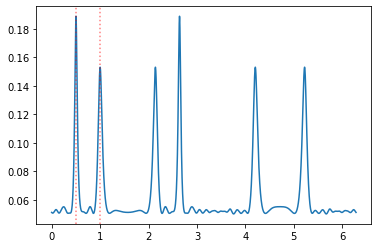

In [11]:
# spectrum = mic_array_spectrum_function(noise_eigenvectors, mic_distance=mic_distance, wavelength=wavelength)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

Extract the frequencies from the peaks. Note that our method only works for theta in $\left[0, \frac{\pi}{2} \right]$ because of the symmetry of the complex exponential and sinus function.

In [12]:
estimated_thetas = extract_frequencies(spectrum, n_sources, [0, np.pi / 2])
print(estimated_thetas)

[1.00012602 0.50202651]
